In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
sys.path.append('../../system/')
# from parser import run_parser, convert_pdf_to_jpg     #for image preprocess
from get_similarity.utils.preprocess import preprocess
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore
from langchain_chroma import Chroma
from configs import JD_PATH, COLLECTION, DB_PATH

from insert_chunks import *
from tqdm import tqdm
from collections import Counter, defaultdict

#data download
# Login using e.g. `huggingface-cli login` to access this dataset
# df = pd.read_csv("hf://datasets/AzharAli05/Resume-Screening-Dataset/dataset.csv")

In [2]:
df = pd.read_csv("./resume_screening_dataset.csv")

In [3]:
df.columns

Index(['Role', 'Resume', 'Decision', 'Reason_for_decision', 'Job_Description'], dtype='object')

In [4]:
df.head()

Role  \
0       E-commerce Specialist   
1              Game Developer   
2  Human Resources Specialist   
3       E-commerce Specialist   
4       E-commerce Specialist   

                                              Resume Decision  \
0  Here's a professional resume for Jason Jones:\...   reject   
1  Here's a professional resume for Ann Marshall:...   select   
2  Here's a professional resume for Patrick Mccla...   reject   
3  Here's a professional resume for Patricia Gray...   select   
4  Here's a professional resume for Amanda Gross:...   reject   

                                 Reason_for_decision  \
0    Lacked leadership skills for a senior position.   
1              Strong technical skills in AI and ML.   
2  Insufficient system design expertise for senio...   
3  Impressive leadership and communication abilit...   
4    Lacked leadership skills for a senior position.   

                                     Job_Description  
0  Be part of a passionate team at the forefront ...  
1  Help us build the next-generation products as ...  
2  We need a Human Resources Specialist to enhanc...  
3  Be part of a passionate team at the forefront ...  
4  We are looking for an experienced E-commerce S...

In [5]:
for i in range(5):
    print(df["Job_Description"][i])
    print(">>"*30)

Be part of a passionate team at the forefront of machine learning as a E-commerce Specialist, delivering solutions that shape the future.
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Help us build the next-generation products as a Game Developer and work with a dynamic, cross-functional team.
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
We need a Human Resources Specialist to enhance our team's technical capabilities and contribute to solving complex business challenges.
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Be part of a passionate team at the forefront of cloud computing as a E-commerce Specialist, delivering solutions that shape the future.
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
We are looking for an experienced E-commerce Specialist to join our team and help drive groundbreaking solutions in data science.
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


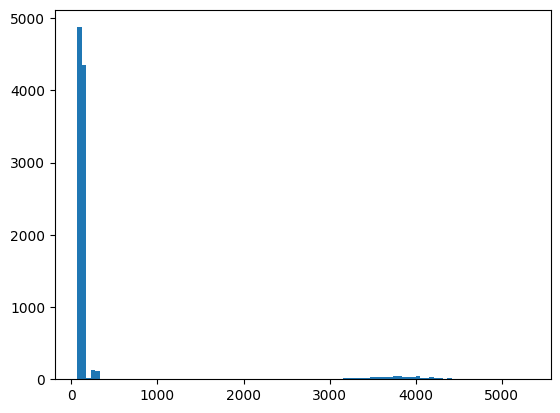

In [6]:
plt.hist(df["Job_Description"].apply(len), bins=100)
plt.show()

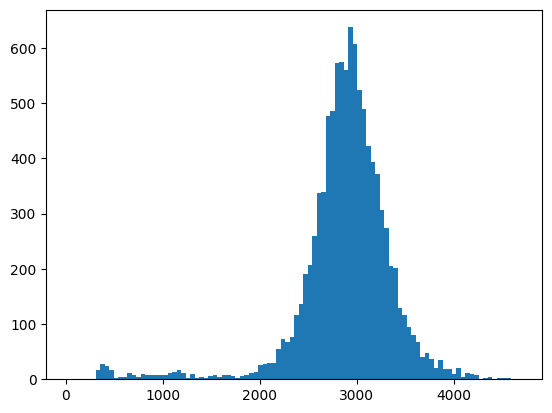

In [7]:
plt.hist(df["Resume"].apply(len), bins=100)
plt.show()

- Resume, JD, Decision만 사용할 예정
- 생성데이터라 그런지 Resume쪽은 분포가 좋아보이고 JD는 조금 애매해보이나 일단 벤치마크부터 진행

In [8]:
print(len(np.unique(df["Job_Description"])))
print(len(df["Job_Description"]))

3446
10174


In [9]:
print(len(np.unique(df["Resume"])))
print(len(df["Resume"]))

10174
10174


In [10]:
jd_counter = Counter()
for jd in df["Job_Description"]:
    jd_counter[jd]+=1

In [11]:
jd_counter.most_common(10)

[('Join our team as a Product Manager and leverage your 8 years of experience to make an impact and contribute to innovative projects.',
  103),
 ('Join our team as a Product Manager and leverage your 10 years of experience to make an impact and contribute to innovative projects.',
  93),
 ('Join our team as a Product Manager and leverage your 9 years of experience to make an impact and contribute to innovative projects.',
  92),
 ('Join our team as a Product Manager and leverage your 7 years of experience to make an impact and contribute to innovative projects.',
  89),
 ('Join our team as a Product Manager and leverage your 5 years of experience to make an impact and contribute to innovative projects.',
  84),
 ('Join our team as a Product Manager and leverage your 6 years of experience to make an impact and contribute to innovative projects.',
  74),
 ('struggled to effectively communicate ideas., lacked key technical skills for the role.',
  36),
 ('needed improvement in problem-so

In [12]:
for k, v in jd_counter.items():
    print(k)
    print(v)
    break

Be part of a passionate team at the forefront of machine learning as a E-commerce Specialist, delivering solutions that shape the future.
11


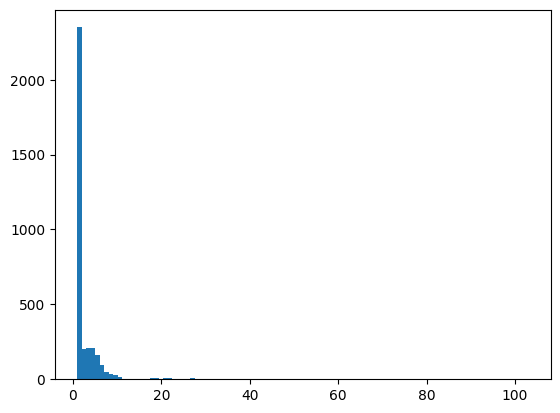

In [13]:
plt.hist([v for k,v in jd_counter.items()], bins=100)
plt.show()

일정 포맷을 기반으로 skill set, 연차 등의 키워드를 넣어서 생성한걸로 보인다  
vectorDB만들기 전 과정을 정리한다면
1. reject는 제거(Retrieval은 matching하는지만 체크하는거니깐)
2. 각 CV마다 id를 붙이고 JD에 metadata로 matching하는 id를 추가
3. 완전히 중복되는 JD제거

In [14]:
df["Decision"]

0        reject
1        select
2        reject
3        select
4        reject
          ...  
10169    reject
10170    reject
10171    select
10172    reject
10173    select
Name: Decision, Length: 10174, dtype: object

In [15]:
df = df[df["Decision"]=="select"]

In [16]:
len(df)

5060

In [17]:
df["id"]=df.index       #컬럼 추가

for i in range(len(df)):
    df["id"].iloc[i]=i

/tmp/ipykernel_14303/2672107778.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["id"].iloc[i]=i
/tmp/ipykernel_14303/2672107778.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

In [18]:
for k, v in jd_counter.items():
    print(k)
    print(v)
    df[df["Job_Description"]==k]
    break

Be part of a passionate team at the forefront of machine learning as a E-commerce Specialist, delivering solutions that shape the future.
11


In [19]:
match_dict = defaultdict(list)
for k, v in jd_counter.items():
    match_dict[k] =df[df["Job_Description"]==k].id.values

In [20]:
df[df["Job_Description"]==k].id

10173    5059
Name: id, dtype: int64

In [21]:
for k, v in match_dict.items():
    print(v)
    result = df[df["id"].isin(v)]["Job_Description"]
    break

[ 253 1557 2001 2722 3982]


In [22]:
for r in result:
    print(r)

Be part of a passionate team at the forefront of machine learning as a E-commerce Specialist, delivering solutions that shape the future.
Be part of a passionate team at the forefront of machine learning as a E-commerce Specialist, delivering solutions that shape the future.
Be part of a passionate team at the forefront of machine learning as a E-commerce Specialist, delivering solutions that shape the future.
Be part of a passionate team at the forefront of machine learning as a E-commerce Specialist, delivering solutions that shape the future.
Be part of a passionate team at the forefront of machine learning as a E-commerce Specialist, delivering solutions that shape the future.


In [23]:
print(len(df["Job_Description"]))
print(len(np.unique(df["Job_Description"])))

5060
2261


In [24]:
filtered_jd = np.unique(df["Job_Description"])

In [25]:
df["Job_Description"]

1        Help us build the next-generation products as ...
3        Be part of a passionate team at the forefront ...
8        As a Digital Marketing Specialist, you'll lead...
9        If you're passionate about software engineerin...
10       We are looking for an experienced UI Engineer ...
                               ...                        
10164    Here is a comprehensive job description for a ...
10166    Here is a comprehensive job description for a ...
10167    Here is a job description for a Data Engineer:...
10171    Here is a job description for a UI Engineer ro...
10173    Here is a comprehensive job description for a ...
Name: Job_Description, Length: 5060, dtype: object

In [29]:
filtered_jd

array(['\n        we are seeking a qualified data engineer with demonstrated expertise in areas such as airflow, data modeling, aws, docker.\n        ideal candidates should have a strong understanding of industry trends and the ability to collaborate effectively.\n        ',
       '\n        we are seeking a qualified data engineer with demonstrated expertise in areas such as airflow, data warehousing, aws, etl.\n        ideal candidates should have a strong understanding of industry trends and the ability to collaborate effectively.\n        ',
       '\n        we are seeking a qualified data engineer with demonstrated expertise in areas such as airflow, data warehousing, etl, spark.\n        ideal candidates should have a strong understanding of industry trends and the ability to collaborate effectively.\n        ',
       ...,
       'we are looking for a skilled ui engineer with expertise in wireframing, javascript, html, ui/ux design.',
       'we are looking for a skilled ui e

In [32]:
df[df["Job_Description"]==filtered_jd[0]]

Role                                             Resume  \
9594  data engineer  harshitha chopra\ncontact information:\n\n* em...   

     Decision  Reason_for_decision  \
9594   select  technical knowledge   

                                        Job_Description    id  
9594  \n        we are seeking a qualified data engi...  4775

In [33]:
for i in range(1000):
    if len(match_dict[filtered_jd[i]])!=1:
        break

In [34]:
print(i)
print(match_dict[filtered_jd[i]])

217
[1250 2209 2689]


In [35]:
df[df["id"].isin([1250, 2209, 2689])]

Role                                             Resume  \
2546  AI Researcher  Here's a sample resume for Sharon Griffin, an ...   
4434  AI Researcher  Here's a sample resume for Ashley Baird, an AI...   
5360  AI Researcher  Here is a sample resume for Ashley Walker:\n\n...   

     Decision                                Reason_for_decision  \
2546   select       Excellent full-stack development experience.   
4434   select              Strong technical skills in AI and ML.   
5360   select  Impressive leadership and communication abilit...   

                                        Job_Description    id  
2546  As a AI Researcher, you will play a pivotal ro...  1250  
4434  As a AI Researcher, you will play a pivotal ro...  2209  
5360  As a AI Researcher, you will play a pivotal ro...  2689

- df["id"]: CV당 고유한 id, matching label용
- match_dict: {k: jd}, {v: id list}
- filtered_jd: matching되는, 유니크한 JD array

# Make VectorDB(same with insert_chunks)

In [36]:
JD_PATH = "../../data/jd_origin"
jd_folder = JD_PATH
for jd_path in os.listdir(jd_folder):
    full_path = os.path.join(jd_folder, jd_path)
#일단 chunk가 어떤느낌으로 만드는지 뜯어보자

In [37]:
emb_model = load_emb_model()
preprocessed_doc = preprocess(full_path)    #dataframe
total_chunks = get_chunks(preprocessed_doc, set_splitter(emb_model))

In [38]:
total_chunks[0].metadata

{'job_url': 'https://www.indeed.com/viewjob?jk=301b28f66c774252',
 'title': 'Engineer',
 'company': 'Realign LLC',
 'company_url': 'https://www.indeed.com/cmp/Realign',
 'location': 'Minneapolis, MN, USA',
 'job_type': 'contract',
 'date_posted': '2024-11-12',
 'is_remote': False,
 'description': "#####  **Job Type: Contract**\n\n##### **Job Category: IT**\n\n#### **Job Description**\n\nJob Title: Azure GenAI Engineer\n\nJob Summary:\n\nWe are seeking a highly skilled Azure GenAI Engineer to join our team and help\ndrive the development and implementation of cutting-edge artificial\nintelligence solutions on the Azure platform. The ideal candidate will have a\ndeep understanding of Azure services, machine learning models, and data\nanalytics to create robust and scalable AI solutions for our clients.\n\nResponsibilities and Duties:\n\n  * Design, develop, and deploy artificial intelligence models on the Azure platform\n  * Collaborate with cross-functional teams to understand business 

In [39]:
print(total_chunks[0].page_content)

#####  **Job Type: Contract**

##### **Job Category: IT**

#### **Job Description**

Job Title: Azure GenAI Engineer

Job Summary:

We are seeking a highly skilled Azure GenAI Engineer to join our team and help
drive the development and implementation of cutting-edge artificial
intelligence solutions on the Azure platform. The ideal candidate will have a
deep understanding of Azure services, machine learning models, and data
analytics to create robust and scalable AI solutions for our clients.


In [40]:
db = Chroma.from_documents(total_chunks, emb_model, persist_directory="./temp_vectorDB", collection_name=COLLECTION)

⚠️ It looks like you upgraded from a version below 0.5.6 and could benefit from vacuuming your database. Run chromadb utils vacuum --help for more information.


In [41]:
db.similarity_search("Data Science", k=5)

[Document(id='eedd6a18-0961-47b9-829f-20c97c51bec2', metadata={'company': 'CliftonLarsonAllen', 'company_url': 'https://www.indeed.com/cmp/Cliftonlarsonallen', 'date_posted': '2024-11-11', 'description': "CLA is a top 10 national professional services firm where our purpose is to\n_create opportunities_ every day, for our clients, our people, and our\ncommunities through industry-focused wealth advisory, digital, audit, tax,\nconsulting, and outsourcing services. Even with more than 8,500 people, 130\nU.S. locations, and a global reach, we promise to know you and help you.\n\nCLA is dedicated to building a\n\nculture\n\nthat invites different beliefs and perspectives to the table, so we can truly\nknow and help our clients, communities, and each other.\n\nOur Perks:\n\n  * Flexible PTO (designed to offer flexible time away for you!)\n  * Up to 12 weeks paid parental leave\n  * Paid Volunteer Time Off\n  * Mental health coverage\n  * Quarterly Wellness stipend\n  * Fertility benefits\n 

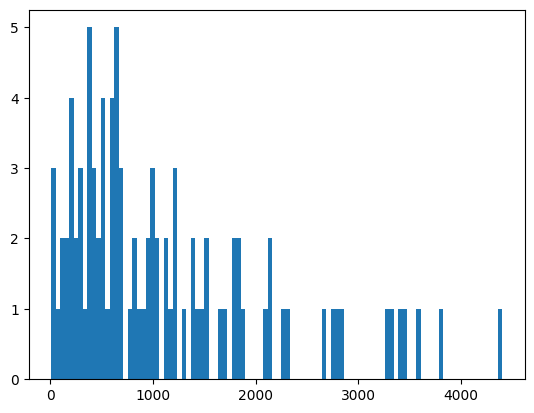

In [42]:
plt.hist([len(chunk.page_content) for chunk in total_chunks], bins=100)
plt.show()

# Make VectorDB(Benchmark dataset)

In [43]:
benchmark_JD = filtered_jd

In [ ]:
def get_chunks_bench(df, text_splitter):
    # for i, desciption in enumerate(df["description"]):
        # meta_data = [df.loc[i, df.columns != 'description'].to_dict()]
        # meta_data = [df.loc[i].to_dict()]
    for desciption in (tqdm(df)):
        chunk = text_splitter.create_documents([desciption], [{"result":", ".join(map(str, match_dict[desciption]))}])
        total_chunks.extend(chunk)
    return total_chunks

In [46]:
benchmark_chunks = get_chunks_bench(benchmark_JD, set_splitter(emb_model))

100%|██████████| 2261/2261 [00:02<00:00, 942.59it/s]


In [47]:
db = Chroma.from_documents(benchmark_chunks, emb_model, persist_directory="./benchmark", collection_name="benchmark_0")

In [48]:
match_dict["As a Data Scientist, you'll lead the design and development of cutting-edge data analysis."]

array([1393, 1499, 2752])

In [49]:
len(db.get()["ids"])

3260